In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape, TimeSeriesKMeans
import hdbscan

In [200]:
#Load all UCR Timeseries Data
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import LabelEncoder

ucr = UCR_UEA_datasets()
# UCR/UEA univariate and multivariate datasets.
all_ucr_datasets = ucr.list_datasets()


def load_ucr(dataset):
    X_train, y_train, X_test, y_test = ucr.load_dataset(dataset)
    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))
    if dataset == 'HandMovementDirection':  # this one has special labels
        y = [yy[0] for yy in y]
    y = LabelEncoder().fit_transform(y)  # sometimes labels are strings or start from 1
    assert(y.min() == 0)  # assert labels are integers and start from 0
    # preprocess data (standardization)
    X_scaled = TimeSeriesScalerMeanVariance(mu=0, std=1).fit_transform(X)
    return X_scaled, y


def load_data(dataset_name):
    if dataset_name in all_ucr_datasets:
        return load_ucr(dataset_name)
    else:
        print('Dataset {} not available! Available datasets are UCR/UEA univariate and multivariate datasets.'.format(dataset_name))
        exit(0)

In [184]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])
data_train = np.loadtxt(current_path+file+"ECGFiveDays/ECGFiveDays_TRAIN.txt")
X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int32)

data_test = np.loadtxt(current_path+file+"ECGFiveDays/ECGFiveDays_TEST.txt")
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int32)

In [22]:
# Basic summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 23
Number of unique classes: 2
Time series length: 136


In [25]:
# Number of examples in each class in the training set
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))

Number of time series in class 1.0: 14
Number of time series in class 2.0: 9


Plot  0  Class  1.0


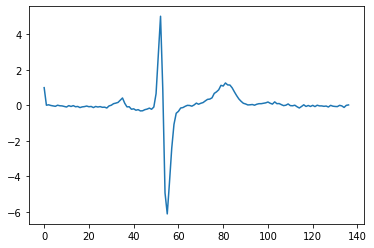

Plot  1  Class  1.0


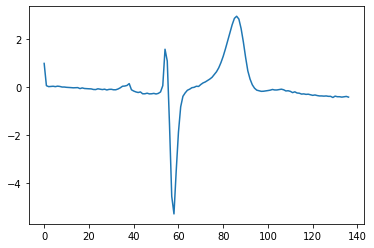

Plot  4  Class  1.0


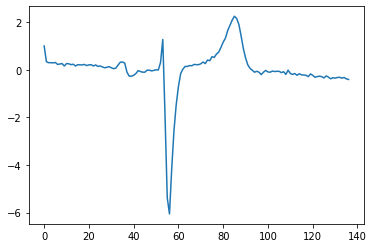

Plot  7  Class  1.0


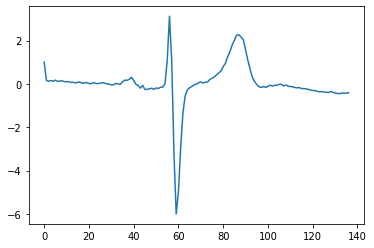

Plot  9  Class  1.0


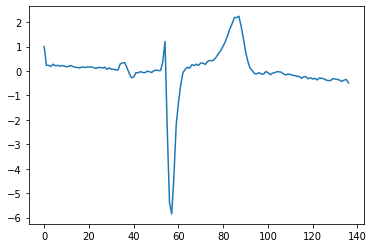

In [26]:
for i in range(0,10):
    if data_train[i,0]==1.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

Plot  2  Class  2.0


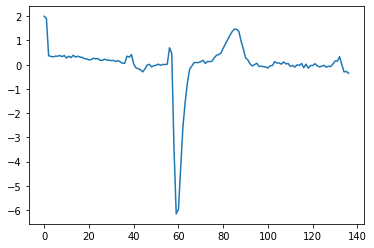

Plot  3  Class  2.0


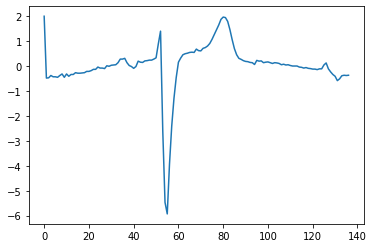

Plot  5  Class  2.0


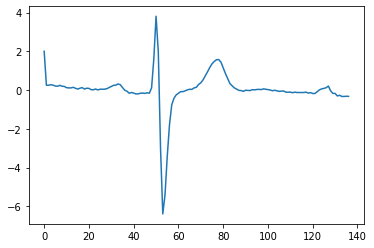

Plot  6  Class  2.0


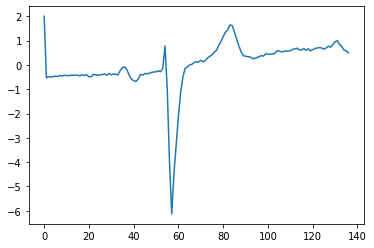

Plot  8  Class  2.0


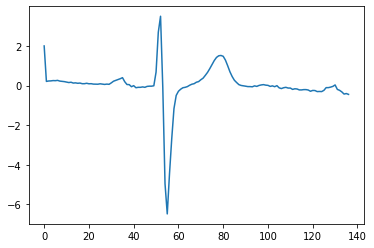

In [27]:
# Examples of Class 2.0
for i in range(0,10):
    if data_train[i,0]==2.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

In [28]:
# Prepare the data - Scale the data to have a mean of - and a stddev of 1
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [29]:
#K-Shape Algorithm 
#set number of clusters to 2 and number of iterations as 100 and raounds to 100
# Train using k-Shape
ks = KShape(n_clusters=2, max_iter=100, n_init=100,verbose=0)
ks.fit(X_train)

KShape(n_clusters=2, n_init=100, verbose=0)

In [30]:
#To measure the goodness of the time series clutering, adjust Rand inxes measures similarity between two data cluterings adjusted for the chance grouping of elements. Related to accuracy
#Rand index mesures the number of agreements in cluster assignments between the predicted cluerings and the true clusterings. 0 is purely random, if 1 they match the true assignment exactly
# Make predictions on train set and calculate adjusted Rand index

preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.668041237113402


In [33]:
# Make predictions on test set and calculate adjusted Rand index
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

#Low value shows only chance variance on the test set - Likely due to small training set

Adjusted Rand Index on Test Set: 0.016330535074783912


In [36]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])
data_train = np.loadtxt(current_path+file+"ECG5000/ECG5000_TRAIN.txt" )

data_test = np.loadtxt(current_path+file+"ECG5000/ECG5000_TEST.txt")

data_joined = np.concatenate((data_train,data_test),axis=0)
data_train, data_test = train_test_split(data_joined, test_size=0.20, random_state=2019)

X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int32)
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int32)

In [37]:
# Summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 4000
Number of unique classes: 5
Time series length: 140


In [38]:
# Calculate number of readings per class
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))
print("Number of time series in class 3.0:", 
      len(data_train[data_train[:,0]==3.0]))
print("Number of time series in class 4.0:", 
      len(data_train[data_train[:,0]==4.0]))
print("Number of time series in class 5.0:", 
      len(data_train[data_train[:,0]==5.0]))

Number of time series in class 1.0: 2327
Number of time series in class 2.0: 1423
Number of time series in class 3.0: 75
Number of time series in class 4.0: 156
Number of time series in class 5.0: 19


Plot  0  Class  3.0


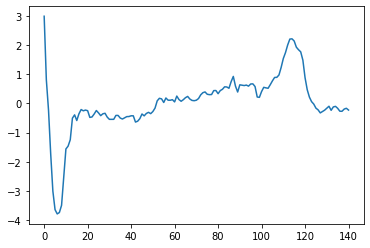

Plot  1  Class  3.0


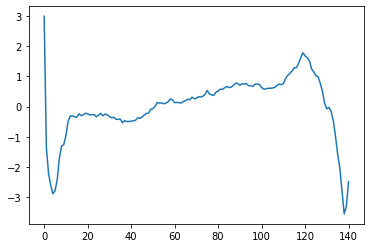

Plot  2  Class  3.0


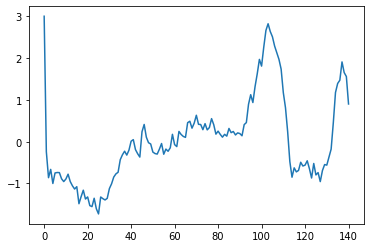

Plot  3  Class  3.0


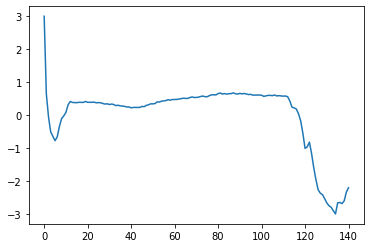

Plot  4  Class  3.0


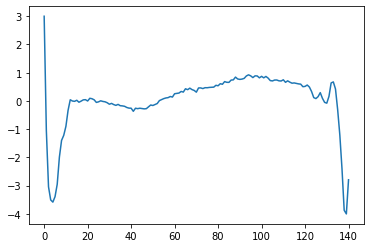

In [59]:
#Specifc examples of each class 

clss=3.0

for i in range(0,5):
    dtaclss = data_train[data_train[:,0] == clss]
    if dtaclss[i,0]==clss:
        print("Plot ",i," Class ",dtaclss[i,0])
        plt.plot(dtaclss[i])
        plt.show()

 Class  1.0  Count  2327


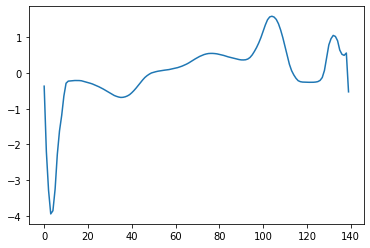

 Class  2.0  Count  1423


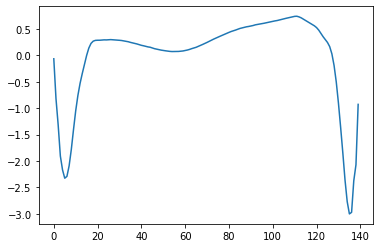

 Class  3.0  Count  75


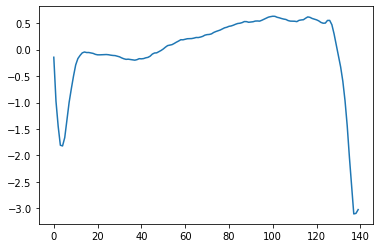

 Class  4.0  Count  156


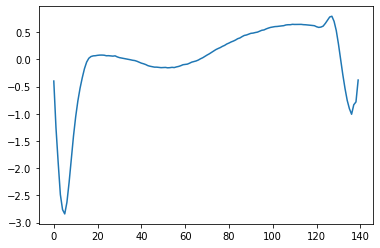

 Class  5.0  Count  19


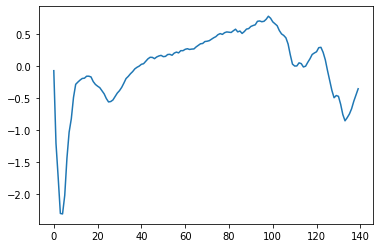

In [39]:
# Display readings from each class as a collective average
for j in np.unique(data_train[:,0]):
    dataPlot = data_train[data_train[:,0]==j]
    cnt = len(dataPlot)
    dataPlot = dataPlot[:,1:].mean(axis=0)
    print(" Class ",j," Count ",cnt)
    plt.plot(dataPlot)
    plt.show()

In [60]:
# Prepare data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [63]:
#Test Time Series Clustering Algos on Sample of ECG 5000

# Train using k-Shape
ks = KShape(n_clusters=5, max_iter=100, n_init=10,verbose=1,random_state=2019)
ks.fit(X_train)

Init 1
0.015 --> 0.015 --> 
Init 2
0.014 --> 0.014 --> 
Init 3
0.018 --> 0.017 --> 0.018 --> 
Init 4
0.017 --> 0.016 --> 0.018 --> 
Init 5
0.016 --> 0.017 --> 
Init 6
0.012 --> 0.012 --> 
Init 7
0.016 --> 0.014 --> 0.016 --> 
Init 8
0.015 --> 0.014 --> 0.015 --> 
Init 9
0.017 --> 0.017 --> 0.018 --> 
Init 10
0.015 --> 0.016 --> 


KShape(n_clusters=5, n_init=10, random_state=2019, verbose=1)

In [64]:
# Predict on train set and calculate adjusted Rand index
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.5553639462811412


In [70]:
# Predict on test set and calculate adjusted Rand index
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.5301670526070555


In [71]:
# Evaluate goodness of the clusters
#For each cluster, evaluate distribution of true labels 

preds_test = preds_test.reshape(1000,1)
preds_test = np.hstack((preds_test,data_test[:,0].reshape(1000,1)))
preds_test = pd.DataFrame(data=preds_test)
preds_test = preds_test.rename(columns={0: 'prediction', 1: 'actual'})

counter = 0
for i in np.sort(preds_test.prediction.unique()):
    print("Predicted Cluster ", i)
    print(preds_test.actual[preds_test.prediction==i].value_counts())
    print()
    cnt = preds_test.actual[preds_test.prediction==i] \
                        .value_counts().iloc[1:].sum()
    counter = counter + cnt
print("Count of Non-Primary Points: ", counter)

Predicted Cluster  0.0
2.0    127
3.0      9
4.0      6
5.0      1
Name: actual, dtype: int64

Predicted Cluster  1.0
2.0    197
1.0     18
4.0      9
3.0      3
Name: actual, dtype: int64

Predicted Cluster  2.0
2.0    18
4.0    18
5.0     3
3.0     2
1.0     2
Name: actual, dtype: int64

Predicted Cluster  3.0
1.0    130
3.0      3
4.0      2
2.0      1
5.0      1
Name: actual, dtype: int64

Predicted Cluster  4.0
1.0    442
3.0      4
4.0      3
2.0      1
Name: actual, dtype: int64

Count of Non-Primary Points:  86


In [72]:
#Time Series K-Means Clustering

km = TimeSeriesKMeans(n_clusters=5, max_iter=100, n_init=100, metric="euclidean", verbose=1, random_state=2019)
km.fit(X_train)

Init 1
36.241 --> 27.298 --> 26.273 --> 25.556 --> 25.120 --> 24.912 --> 24.831 --> 24.815 --> 24.813 --> 24.812 --> 24.812 --> 24.812 --> 24.812 --> 
Init 2
37.226 --> 25.264 --> 24.680 --> 24.430 --> 24.296 --> 24.202 --> 24.155 --> 24.136 --> 24.128 --> 24.124 --> 24.121 --> 24.119 --> 24.118 --> 24.117 --> 24.117 --> 24.117 --> 24.117 --> 24.116 --> 24.116 --> 24.116 --> 24.116 --> 24.115 --> 24.115 --> 24.115 --> 24.114 --> 24.113 --> 24.112 --> 24.111 --> 24.110 --> 24.109 --> 24.108 --> 24.108 --> 24.108 --> 
Init 3
33.738 --> 25.341 --> 25.014 --> 24.795 --> 24.664 --> 24.623 --> 24.616 --> 24.615 --> 24.614 --> 24.614 --> 24.614 --> 
Init 4
30.531 --> 24.956 --> 24.740 --> 24.663 --> 24.629 --> 24.615 --> 24.603 --> 24.595 --> 24.585 --> 24.567 --> 24.560 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 24.559 --> 
Init 5
34.030 --> 25.598 --> 25.398 --> 25.344 --> 25.310 --> 25.277 --> 25.236 --> 25.159 --> 25.005 --> 24.834 --> 24.725 --> 24.666 --> 24.636 --> 24.6

TimeSeriesKMeans(max_iter=100, n_clusters=5, n_init=100, random_state=2019,
                 verbose=1)

In [73]:
# Predict on training set and evaluate using adjusted Rand index
preds = km.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index of Time Series k-Means on Training Set:", ars)

Adjusted Rand Index of Time Series k-Means on Training Set: 0.5063464656715959


In [74]:

# Predict on test set and evaluate using adjusted Rand index
preds_test = km.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index of Time Series k-Means on Test Set:", ars)

Adjusted Rand Index of Time Series k-Means on Test Set: 0.4864981997585834


In [75]:
#HDB SCAN
# Train model and evaluate on training set
min_cluster_size = 5
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'
prediction_data = True

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                      min_samples=min_samples, alpha=alpha, \
                      cluster_selection_method=cluster_selection_method, \
                      prediction_data=prediction_data)

preds = hdb.fit_predict(X_train.reshape(4000,140))
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.7628260922190984


In [96]:
# Predict on test set and evaluate
preds_test = hdbscan.prediction.approximate_predict( \
                hdb, X_test.reshape(1000,140))
ars = adjusted_rand_score(data_test[:,0],preds_test[0])
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.7230550599125711


In [97]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])

mypath = current_path + file
d = []
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    for i in dirnames:
        newpath = os.path.sep.join([mypath, i, ""])
        onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
        f.extend(onlyfiles)
    d.extend(dirnames)
    break

In [98]:
# Create dataframe
kShapeDF = pd.DataFrame(data=[],index=[v for v in d],columns=["Train ARS","Test ARS"])

In [208]:
# Train and Evaluate k-Shape
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))
        return (time.time() - self.start_time)


arslist = []

timer = ElapsedTimer()
cnt = 0
for i in all_ucr_datasets:
    cnt += 1
    print("Dataset ", cnt)
    X, y = load_ucr(i) # Returns all X and Y data scaled
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(X_train)
    y_train = y_train.astype(np.int32)
    X_test = to_time_series_dataset(X_test)
    y_test = y_test.astype(np.int32)
    
    # X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \ # Not needed, data scaled already

    #                             .fit_transform(X_train)
    # X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
    #                             .fit_transform(X_test)
    
    classes = len(np.unique(y))
    ks = KShape(n_clusters=classes, max_iter=10, n_init=3,verbose=0)
    ks.fit(X_train)

    print(i)
    preds = ks.predict(X_train)
    ars = adjusted_rand_score(y_train,preds)
    print("Adjusted Rand Index on Training Set:", ars)
    kShapeDF.loc[i,"Train ARS"] = ars
    
    preds_test = ks.predict(X_test)
    ars = adjusted_rand_score(y_test,preds_test)
    print("Adjusted Rand Index on Test Set:", ars)
    kShapeDF.loc[i,"Test ARS"] = ars
    
kShapeTime = timer.elapsed_time() 

Dataset  1
Adiac
Adjusted Rand Index on Training Set: 0.06566630908713406
Adjusted Rand Index on Test Set: 0.06791975411205586
Dataset  2
ArrowHead
Adjusted Rand Index on Training Set: 0.2101971720126713
Adjusted Rand Index on Test Set: 0.25519704056383385
Dataset  3
Beef
Adjusted Rand Index on Training Set: 0.04234897213932193
Adjusted Rand Index on Test Set: -0.01060070671378092
Dataset  4
BeetleFly
Adjusted Rand Index on Training Set: -0.01601339597795516
Adjusted Rand Index on Test Set: -0.10344827586206896
Dataset  5
BirdChicken
Adjusted Rand Index on Training Set: 0.010339925035543492
Adjusted Rand Index on Test Set: 0.0
Dataset  6
Car
Adjusted Rand Index on Training Set: 0.1299338230866363
Adjusted Rand Index on Test Set: 0.03490368109860767
Dataset  7
CBF
Adjusted Rand Index on Training Set: 0.4191438928013241
Adjusted Rand Index on Test Set: 0.43596158682251546
Dataset  8
ChlorineConcentration
Adjusted Rand Index on Training Set: -0.001058777619813621
Adjusted Rand Index on Te

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\tslearn\datasets\datasets.py:49: RuntimeWarning: Corrupted or missing zip file encountered, aborting
  warnings.warn("Corrupted or missing zip file encountered, aborting",
C:\Users\JMcKay\AppData\Local\Temp\ipykernel_12472\2604559044.py:12: RuntimeWarning: dataset "AtrialFibrilation" could not be downloaded or extracted
  X_train, y_train, X_test, y_test = ucr.load_dataset(dataset)


ValueError: zero-dimensional arrays cannot be concatenated

In [220]:
# Train and Evaluate k-Shape for 50 datasets
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))
        return (time.time() - self.start_time)

datasetlist = []
arslisttest = []
arslisttrain = []

timer = ElapsedTimer()
cnt = 0
for i in all_ucr_datasets[:50]:
    cnt += 1
    print("Dataset ", cnt)
    datasetlist.append(i)

    X, y = load_ucr(i) # Returns all X and Y data scaled
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(X_train)
    y_train = y_train.astype(np.int32)
    X_test = to_time_series_dataset(X_test)
    y_test = y_test.astype(np.int32)
    
    # X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \ # Not needed, data scaled already

    #                             .fit_transform(X_train)
    # X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
    #                             .fit_transform(X_test)
    
    classes = len(np.unique(y))
    ks = KShape(n_clusters=classes, max_iter=10, n_init=3,verbose=0)
    ks.fit(X_train)
    print(i)
    preds = ks.predict(X_train)
    ars = adjusted_rand_score(y_train,preds)
    arslisttrain.append(ars)
    print("Adjusted Rand Index on Training Set:", ars)
    kShapeDF.loc[i,"Train ARS"] = ars
    
    preds_test = ks.predict(X_test)
    ars = adjusted_rand_score(y_test,preds_test)
    arslisttest.append(ars)
    print("Adjusted Rand Index on Test Set:", ars)
    kShapeDF.loc[i,"Test ARS"] = ars
    
kShapeTime = timer.elapsed_time() 

Dataset  1
Adiac
Adjusted Rand Index on Training Set: 0.2307463135210298
Adjusted Rand Index on Test Set: 0.21749287804866396
Dataset  2
ArrowHead
Adjusted Rand Index on Training Set: 0.13115866501141535
Adjusted Rand Index on Test Set: 0.04137742280610087
Dataset  3
Beef
Adjusted Rand Index on Training Set: 0.10401016726051336
Adjusted Rand Index on Test Set: -0.02990897269180754
Dataset  4
BeetleFly
Adjusted Rand Index on Training Set: 0.06769951829188908
Adjusted Rand Index on Test Set: 0.0
Dataset  5
BirdChicken
Adjusted Rand Index on Training Set: 0.1679740680713128
Adjusted Rand Index on Test Set: -0.14871794871794872
Dataset  6
Car
Adjusted Rand Index on Training Set: 0.12402464262467726
Adjusted Rand Index on Test Set: 0.03490368109860767
Dataset  7
CBF
Adjusted Rand Index on Training Set: 0.4459869778474124
Adjusted Rand Index on Test Set: 0.4550905238561833
Dataset  8
ChlorineConcentration
Adjusted Rand Index on Training Set: 0.0009529722203974177
Adjusted Rand Index on Test 

In [221]:
KShapeSummary = pd.DataFrame({"dataset":datasetlist, "ARS Train":arslisttrain, "ARS Test": arslisttest})
KShapeSummary

,dataset,ARS Train,ARS Test
0,Adiac,0.230746,0.217493
1,ArrowHead,0.131159,0.041377
2,Beef,0.104010,-0.029909
3,BeetleFly,0.067700,0.000000
4,BirdChicken,0.167974,-0.148718
5,Car,0.124025,0.034904
6,CBF,0.445987,0.455091
7,ChlorineConcentration,0.000953,0.004901
8,CinCECGTorso,0.025474,0.028947
9,Coffee,0.010482,0.022222


In [223]:
# Train and Evaluate k-Means for 50 datasets - Modified source data
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))
        return (time.time() - self.start_time)

datasetlist = []
arslisttest = []
arslisttrain = []

timer = ElapsedTimer()
cnt = 0
for i in all_ucr_datasets[:50]:
    cnt += 1
    print("Dataset ", cnt)
    datasetlist.append(i)

    X, y = load_ucr(i) # Returns all X and Y data scaled
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(X_train)
    y_train = y_train.astype(np.int32)
    X_test = to_time_series_dataset(X_test)
    y_test = y_test.astype(np.int32)
    
    # X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \ # Not needed, data scaled already

    #                             .fit_transform(X_train)
    # X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
    #                             .fit_transform(X_test)
    
    classes = len(np.unique(y))
    km = TimeSeriesKMeans(n_clusters=5, max_iter=10, n_init=10, metric='euclidean', verbose=0, random_state=2019)
    km.fit(X_train)

    print(i)
    preds = km.predict(X_train)
    ars = adjusted_rand_score(y_train,preds)
    arslisttrain.append(ars)
    print("Adjusted Rand Index on Training Set:", ars)
    #kShapeDF.loc[i,"Train ARS"] = ars
    
    preds_test = km.predict(X_test)
    ars = adjusted_rand_score(y_test,preds_test)
    arslisttest.append(ars)
    print("Adjusted Rand Index on Test Set:", ars)
    #kShapeDF.loc[i,"Test ARS"] = ars
    
kSMeansTime = timer.elapsed_time()

KMeansSummary = pd.DataFrame({"dataset":datasetlist, "ARS Train":arslisttrain, "ARS Test": arslisttest})

Dataset  1
Adiac
Adjusted Rand Index on Training Set: 0.046457360143610384
Adjusted Rand Index on Test Set: 0.04692905800287683
Dataset  2
ArrowHead
Adjusted Rand Index on Training Set: 0.18404864150543349
Adjusted Rand Index on Test Set: 0.10421867545757219
Dataset  3
Beef
Adjusted Rand Index on Training Set: 0.08069432684165961
Adjusted Rand Index on Test Set: -0.01060070671378092
Dataset  4
BeetleFly
Adjusted Rand Index on Training Set: 0.18802811078958248
Adjusted Rand Index on Test Set: 0.40106951871657753
Dataset  5
BirdChicken
Adjusted Rand Index on Training Set: 0.06500206696982225
Adjusted Rand Index on Test Set: 0.10160427807486631
Dataset  6
Car
Adjusted Rand Index on Training Set: 0.09488043905854793
Adjusted Rand Index on Test Set: 0.011605544134226408
Dataset  7
CBF
Adjusted Rand Index on Training Set: 0.2450538205949986
Adjusted Rand Index on Test Set: 0.2700781062242623
Dataset  8
ChlorineConcentration
Adjusted Rand Index on Training Set: 0.00036199252476776104
Adjusted

In [228]:
# Train and Evaluate DBSCAN for 50 datasets - Modified source data
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))
        return (time.time() - self.start_time)

datasetlist = []
arslisttest = []
arslisttrain = []

timer = ElapsedTimer()
cnt = 0
for i in all_ucr_datasets[:50]:
    cnt += 1
    print("Dataset ", cnt)
    datasetlist.append(i)

    X, y = load_ucr(i) # Returns all X and Y data scaled
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(X_train)
    y_train = y_train.astype(np.int32)
    X_test = to_time_series_dataset(X_test)
    y_test = y_test.astype(np.int32)

    classes = len(np.unique(y))
    min_cluster_size = 5
    min_samples = None
    alpha = 1.0
    cluster_selection_method = 'eom'
    prediction_data = True

    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, alpha=alpha, cluster_selection_method=cluster_selection_method, prediction_data=prediction_data)
    print(i)
    
    preds = hdb.fit_predict(X_train.reshape(X_train.shape[0],X_train.shape[1]))
    ars = adjusted_rand_score(y_train,preds)
    arslisttrain.append(ars)
    print("Adjusted Rand Index on Training Set:", ars)
    #kShapeDF.loc[i,"Train ARS"] = ars
    
    preds_test = hdbscan.prediction.approximate_predict(hdb, X_test.reshape(X_test.shape[0], X_test.shape[1]))
    ars = adjusted_rand_score(y_test,preds_test[0])
    arslisttest.append(ars)
    print("Adjusted Rand Index on Test Set:", ars)
    #kShapeDF.loc[i,"Test ARS"] = ars
    
hdbscanTime = timer.elapsed_time()

hdbscanSummary = pd.DataFrame({"dataset":datasetlist, "ARS Train":arslisttrain, "ARS Test": arslisttest})

Dataset  1
Adiac
Adjusted Rand Index on Training Set: 0.00652543253780241
Adjusted Rand Index on Test Set: 0.006331602513229232
Dataset  2
ArrowHead
Adjusted Rand Index on Training Set: 0.06550159969172853
Adjusted Rand Index on Test Set: 0.04176078006869923
Dataset  3
Beef
Adjusted Rand Index on Training Set: 0.07675278820826094
Adjusted Rand Index on Test Set: 0.09488510007412898
Dataset  4
BeetleFly
Adjusted Rand Index on Training Set: 0.0
Adjusted Rand Index on Test Set: 0.0
Dataset  5
BirdChicken
Adjusted Rand Index on Training Set: 0.0
Adjusted Rand Index on Test Set: 0.0
Dataset  6
Car
Adjusted Rand Index on Training Set: 0.0
Adjusted Rand Index on Test Set: 0.0
Dataset  7


c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\hdbscan\prediction.py:382: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\hdbscan\prediction.py:382: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\hdbscan\prediction.py:382: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


CBF
Adjusted Rand Index on Training Set: 0.2854561745014572
Adjusted Rand Index on Test Set: 0.27383809545485444
Dataset  8
ChlorineConcentration
Adjusted Rand Index on Training Set: 0.0047452435296889426
Adjusted Rand Index on Test Set: 0.005107736478006364
Dataset  9
CinCECGTorso
Adjusted Rand Index on Training Set: 0.5859338962503325
Adjusted Rand Index on Test Set: 0.5772440045157653
Dataset  10
Coffee
Adjusted Rand Index on Training Set: 0.34607018855349253
Adjusted Rand Index on Test Set: 0.367816091954023
Dataset  11
Computers
Adjusted Rand Index on Training Set: 0.001140257514238619
Adjusted Rand Index on Test Set: -0.006464646464646465
Dataset  12
CricketX
Adjusted Rand Index on Training Set: 0.041046471358365276
Adjusted Rand Index on Test Set: 0.044351219181192156
Dataset  13
CricketY
Adjusted Rand Index on Training Set: 0.019979351643007
Adjusted Rand Index on Test Set: 0.006532140617179253
Dataset  14
CricketZ
Adjusted Rand Index on Training Set: 0.0253621840033341
Adjuste

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\hdbscan\prediction.py:382: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


HandOutlines
Adjusted Rand Index on Training Set: 0.06904424147558559
Adjusted Rand Index on Test Set: 0.03748248132947282
Dataset  34
Haptics
Adjusted Rand Index on Training Set: 0.05469678121021432
Adjusted Rand Index on Test Set: 0.006873558175631492
Dataset  35
Herring
Adjusted Rand Index on Training Set: 0.0
Adjusted Rand Index on Test Set: 0.0
Dataset  36


c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\hdbscan\prediction.py:382: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


InlineSkate
Adjusted Rand Index on Training Set: 0.018366441788236394
Adjusted Rand Index on Test Set: -0.015130790184342718
Dataset  37
InsectWingbeatSound
Adjusted Rand Index on Training Set: 0.1457186575036397
Adjusted Rand Index on Test Set: 0.14433645819199725
Dataset  38
ItalyPowerDemand
Adjusted Rand Index on Training Set: 0.032642870784244916
Adjusted Rand Index on Test Set: 0.017337900146198373
Dataset  39
LargeKitchenAppliances
Adjusted Rand Index on Training Set: 0.008678001088699197
Adjusted Rand Index on Test Set: 0.018924342770284586
Dataset  40
Lightning2
Adjusted Rand Index on Training Set: 0.06041147949154763
Adjusted Rand Index on Test Set: -0.013333333333333334
Dataset  41
Lightning7
Adjusted Rand Index on Training Set: 0.19369397639991692
Adjusted Rand Index on Test Set: 0.11600766417000523
Dataset  42
Mallat
Adjusted Rand Index on Training Set: 0.5637906949531908
Adjusted Rand Index on Test Set: 0.5656920864671393
Dataset  43
Meat
Adjusted Rand Index on Training Se

In [236]:
print('hdbScan mean')
print(hdbscanSummary.mean())
print('Kshape Means Mean')
print(KShapeSummary.mean())
print('KMeans Mean')
print(KMeansSummary.mean())

hdbScan mean
ARS Train    0.16483
ARS Test     0.14967
dtype: float64
Kshape Means Mean
ARS Train    0.226857
ARS Test     0.198499
dtype: float64
KMeans Mean
ARS Train    0.176205
ARS Test     0.171998
dtype: float64


C:\Users\JMcKay\AppData\Local\Temp\ipykernel_12472\3938577977.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(hdbscanSummary.mean())
C:\Users\JMcKay\AppData\Local\Temp\ipykernel_12472\3938577977.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(KShapeSummary.mean())
C:\Users\JMcKay\AppData\Local\Temp\ipykernel_12472\3938577977.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(KMeansSummary.mean())


In [238]:
hdbscanSummary.set_index('dataset')
KMeansSummary.set_index('dataset')
KShapeSummary.set_index('dataset')

,ARS Train,ARS Test
dataset,,
Adiac,0.230746,0.217493
ArrowHead,0.131159,0.041377
Beef,0.104010,-0.029909
BeetleFly,0.067700,0.000000
BirdChicken,0.167974,-0.148718
Car,0.124025,0.034904
CBF,0.445987,0.455091
ChlorineConcentration,0.000953,0.004901
CinCECGTorso,0.025474,0.028947


In [246]:
# Count top place finishes
timeSeriesClusteringDF = pd.DataFrame(data=[],index=KShapeSummary.index, \
                            columns=["kShapeTest", \
                                    "kMeansTest", \
                                    "hdbscanTest"])

timeSeriesClusteringDF.kShapeTest = KShapeSummary["ARS Test"]
timeSeriesClusteringDF.kMeansTest = KMeansSummary["ARS Test"]
timeSeriesClusteringDF.hdbscanTest = hdbscanSummary["ARS Test"]

tscResults = timeSeriesClusteringDF.copy()

for i in range(0,len(tscResults)):
    maxValue = tscResults.iloc[i].max()
    tscResults.iloc[i][tscResults.iloc[i]==maxValue]=1
    minValue = tscResults .iloc[i].min()
    tscResults.iloc[i][tscResults.iloc[i]==minValue]=-1
    medianValue = tscResults.iloc[i].median()
    tscResults.iloc[i][tscResults.iloc[i]==medianValue]=0

In [247]:
# Show results
tscResultsDF = pd.DataFrame(data=np.zeros((3,3)), \
                index=["firstPlace","secondPlace","thirdPlace"], \
                columns=["kShape", "kMeans","hdbscan"])
tscResultsDF.loc["firstPlace",:] = tscResults[tscResults==1].count().values
tscResultsDF.loc["secondPlace",:] = tscResults[tscResults==0].count().values
tscResultsDF.loc["thirdPlace",:] = tscResults[tscResults==-1].count().values
tscResultsDF

,kShape,kMeans,hdbscan
firstPlace,27.0,12.0,11.0
secondPlace,6.0,30.0,15.0
thirdPlace,17.0,8.0,24.0


In [248]:
tscResults

,kShapeTest,kMeansTest,hdbscanTest
0,1.0,0.0,-1.0
1,-1.0,1.0,0.0
2,-1.0,0.0,1.0
3,0.0,1.0,0.0
4,-1.0,1.0,0.0
5,1.0,0.0,-1.0
6,1.0,-1.0,0.0
7,0.0,-1.0,1.0
8,-1.0,0.0,1.0
9,-1.0,0.0,1.0
